In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.12.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('data/train.csv').drop('Date',axis=1)
val_df = pd.read_csv('data/val.csv').drop('Date',axis=1)
test_df = pd.read_csv('data/test.csv').drop('Date',axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(2646, 15) (756, 15) (217, 15)


## `DataWindow` class 

In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=1000):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [9]:
multi_window = DataWindow(input_width=7, label_width=7, shift=7, label_columns=['Adj Close'])

### Repeat last value 

In [10]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 7, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 7, 1])

In [11]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Adj Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

24/24 [==============================] - 0s 1ms/step - loss: 0.1380 - mean_absolute_error: 0.2158


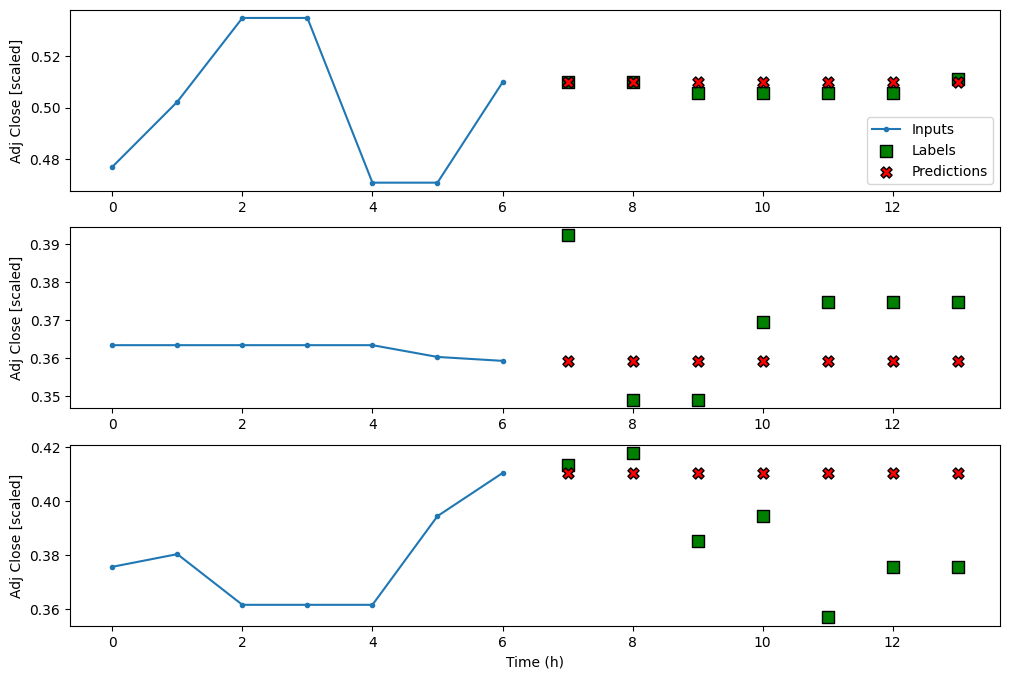

In [12]:
multi_window.plot(baseline_last)

plt.savefig('figures/CH18_F07_peixeiro.png', dpi=300)

### Repeat last day 

In [13]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [14]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Adj Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

24/24 [==============================] - 0s 859us/step - loss: 0.1388 - mean_absolute_error: 0.2206


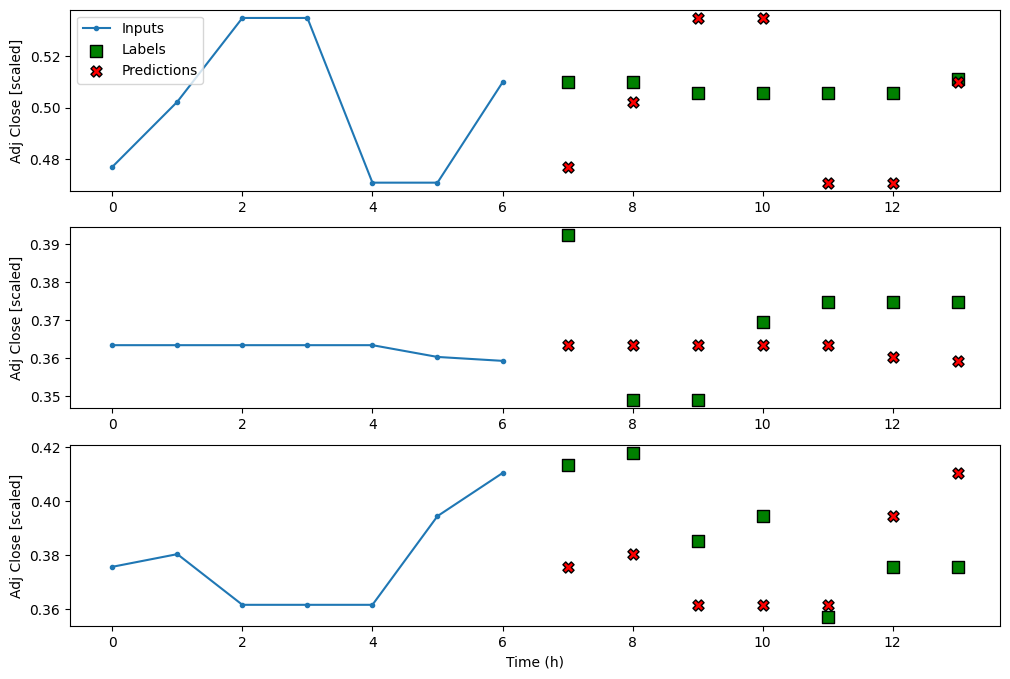

In [15]:
multi_window.plot(baseline_repeat)

plt.savefig('figures/CH18_F08_peixeiro.png', dpi=300)

## Linear model 

In [16]:
label_index = column_indices['Adj Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
83/83 [==============================] - 1s 3ms/step - loss: 0.0703 - mean_absolute_error: 0.2069 - val_loss: 0.0596 - val_mean_absolute_error: 0.2217
Epoch 2/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_absolute_error: 0.0554 - val_loss: 0.0343 - val_mean_absolute_error: 0.1637
Epoch 3/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_absolute_error: 0.0507 - val_loss: 0.0294 - val_mean_absolute_error: 0.1518
Epoch 4/1000
83/83 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_absolute_error: 0.0463 - val_loss: 0.0243 - val_mean_absolute_error: 0.1378
Epoch 5/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0030 - mean_absolute_error: 0.0426 - val_loss: 0.0205 - val_mean_absolute_error: 0.1262
Epoch 6/1000
83/83 [==============================] - 0s 1ms/step - loss: 0.0027 - mean_absolute_error: 0.0397 - val_loss: 0.0175 - val_mean_absolute_error: 0.1162
Epoch 7/1000
83/

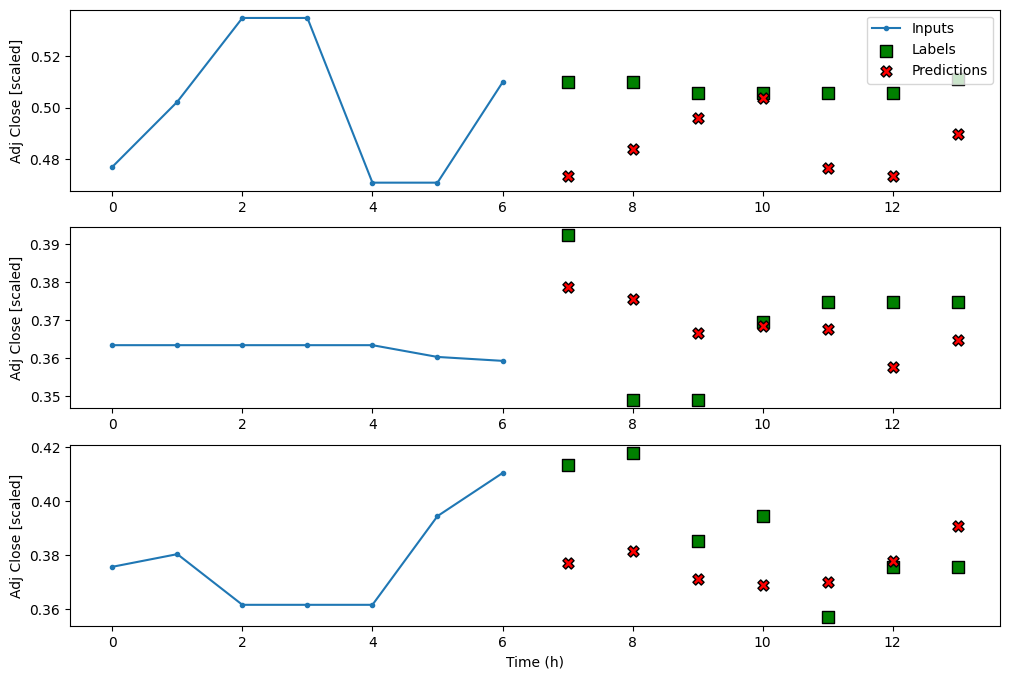

In [17]:
multi_window.plot(linear)

plt.savefig('figures/CH18_F09_peixeiro.png', dpi=300)

## Dense model 

In [18]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
83/83 [==============================] - 1s 4ms/step - loss: 0.0450 - mean_absolute_error: 0.1392 - val_loss: 0.0144 - val_mean_absolute_error: 0.1048
Epoch 2/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0344 - val_loss: 0.0083 - val_mean_absolute_error: 0.0754
Epoch 3/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_absolute_error: 0.0318 - val_loss: 0.0069 - val_mean_absolute_error: 0.0671
Epoch 4/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0312 - val_loss: 0.0048 - val_mean_absolute_error: 0.0521
Epoch 5/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - val_loss: 0.0043 - val_mean_absolute_error: 0.0476
Epoch 6/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0306 - val_loss: 0.0044 - val_mean_absolute_error: 0.0485
Epoch 7/1000
83/

## LSTM model 

In [19]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
83/83 [==============================] - 2s 7ms/step - loss: 0.0728 - mean_absolute_error: 0.2069 - val_loss: 0.1195 - val_mean_absolute_error: 0.2873
Epoch 2/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0094 - mean_absolute_error: 0.0695 - val_loss: 0.0340 - val_mean_absolute_error: 0.1379
Epoch 3/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0459 - val_loss: 0.0197 - val_mean_absolute_error: 0.1093
Epoch 4/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0141 - val_mean_absolute_error: 0.0937
Epoch 5/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0349 - val_loss: 0.0104 - val_mean_absolute_error: 0.0782
Epoch 6/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0337 - val_loss: 0.0100 - val_mean_absolute_error: 0.0778
Epoch 7/1000
83/

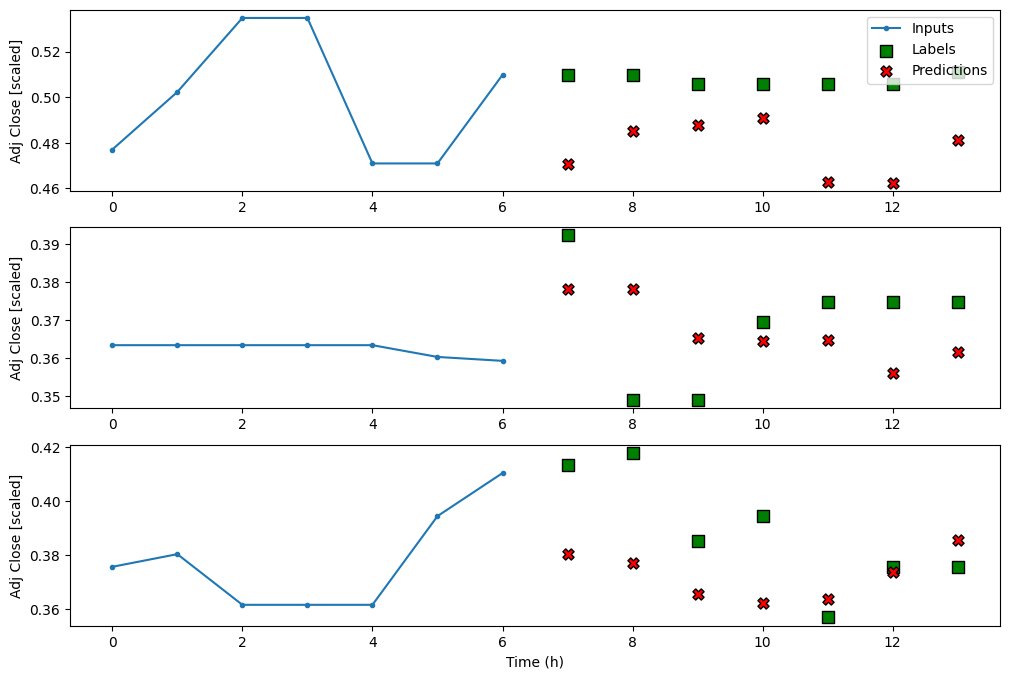

In [20]:
multi_window.plot(lstm_model)

plt.savefig('figures/CH18_F10_peixeiro.png', dpi=300)

## CNN model 

In [21]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=7, label_columns=['Adj Close'])

In [22]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
83/83 [==============================] - 1s 3ms/step - loss: 0.0537 - mean_absolute_error: 0.1589 - val_loss: 0.0261 - val_mean_absolute_error: 0.1449
Epoch 2/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_absolute_error: 0.0405 - val_loss: 0.0101 - val_mean_absolute_error: 0.0843
Epoch 3/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0025 - mean_absolute_error: 0.0377 - val_loss: 0.0098 - val_mean_absolute_error: 0.0833
Epoch 4/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_absolute_error: 0.0355 - val_loss: 0.0137 - val_mean_absolute_error: 0.1025
Epoch 5/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0346 - val_loss: 0.0079 - val_mean_absolute_error: 0.0729
Epoch 6/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0344 - val_loss: 0.0090 - val_mean_absolute_error: 0.0793
Epoch 7/1000
83/

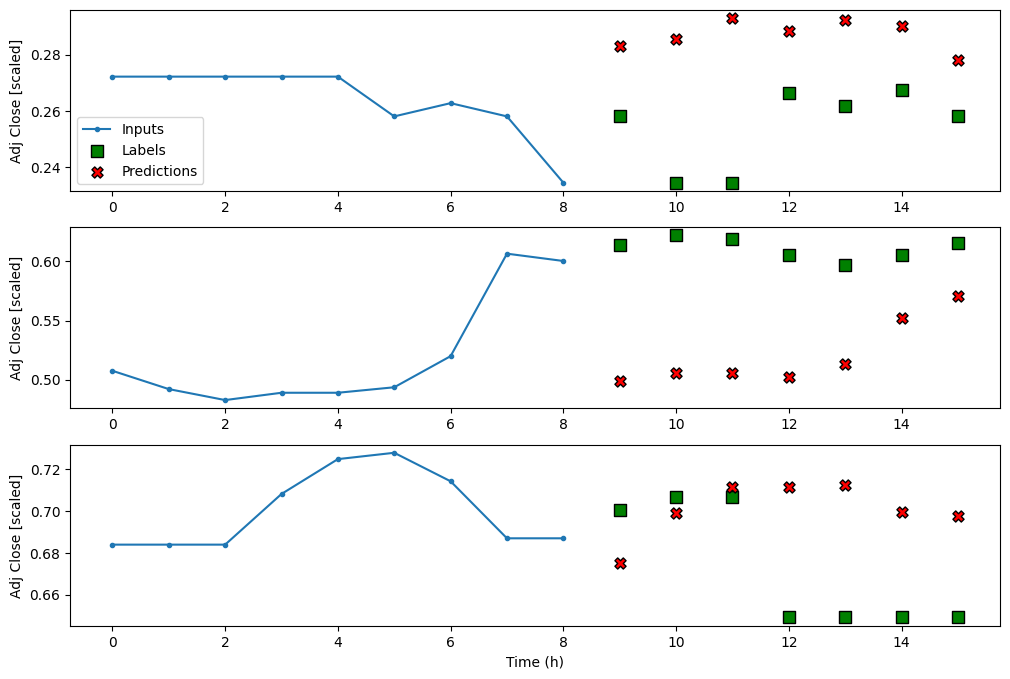

In [23]:
cnn_multi_window.plot(cnn_model)

plt.savefig('figures/CH18_F11_peixeiro.png', dpi=300)

## CNN + LSTM model 

In [24]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
83/83 [==============================] - 2s 8ms/step - loss: 0.0640 - mean_absolute_error: 0.1900 - val_loss: 0.1062 - val_mean_absolute_error: 0.2773
Epoch 2/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_error: 0.0548 - val_loss: 0.0376 - val_mean_absolute_error: 0.1539
Epoch 3/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0405 - val_loss: 0.0264 - val_mean_absolute_error: 0.1288
Epoch 4/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0360 - val_loss: 0.0210 - val_mean_absolute_error: 0.1139
Epoch 5/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0345 - val_loss: 0.0195 - val_mean_absolute_error: 0.1117
Epoch 6/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0341 - val_loss: 0.0146 - val_mean_absolute_error: 0.0917
Epoch 7/1000
83/

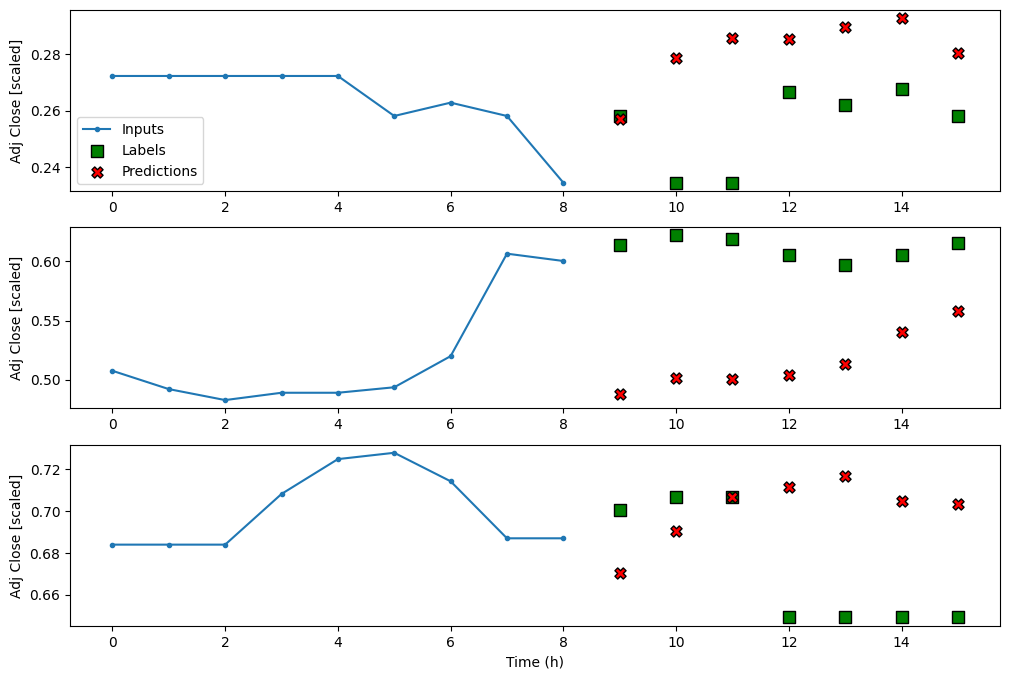

In [25]:
cnn_multi_window.plot(cnn_lstm_model)

plt.savefig('figures/CH18_F12_peixeiro.png', dpi=300)

## Autoregressive LSTM 

In [26]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [27]:
AR_LSTM = AutoRegressive(units=32, out_steps=7)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
83/83 [==============================] - 2s 7ms/step - loss: 0.0440 - mean_absolute_error: 0.1400 - val_loss: 0.0592 - val_mean_absolute_error: 0.1926
Epoch 2/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0411 - val_loss: 0.0207 - val_mean_absolute_error: 0.1126
Epoch 3/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0349 - val_loss: 0.0156 - val_mean_absolute_error: 0.0989
Epoch 4/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0328 - val_loss: 0.0127 - val_mean_absolute_error: 0.0879
Epoch 5/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0330 - val_loss: 0.0117 - val_mean_absolute_error: 0.0847
Epoch 6/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - val_loss: 0.0098 - val_mean_absolute_error: 0.0765
Epoch 7/1000
83/

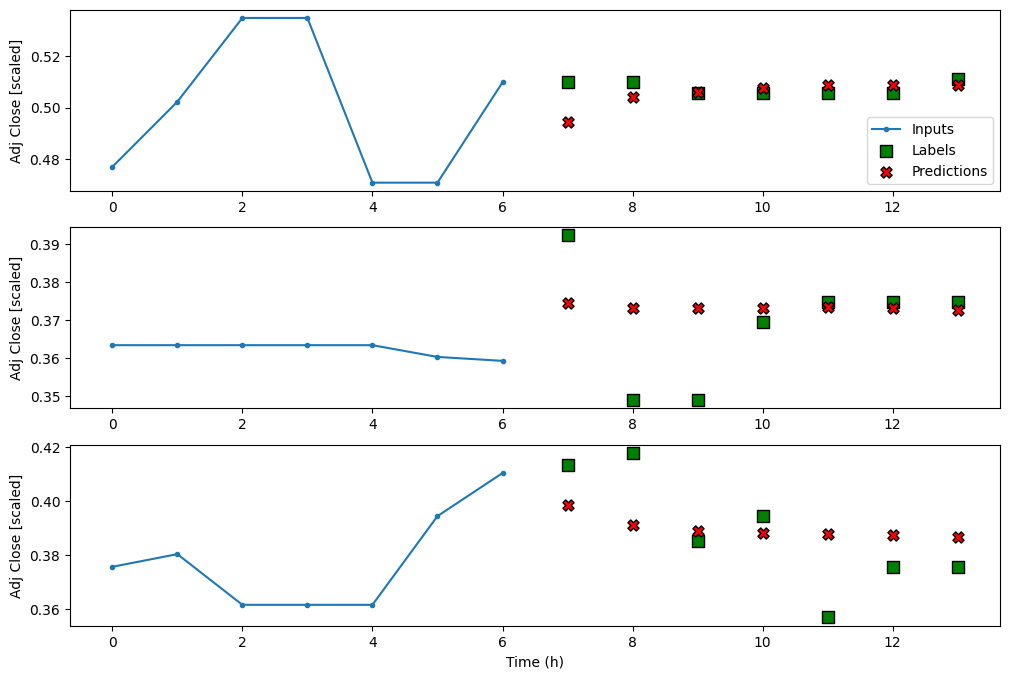

In [28]:
multi_window.plot(AR_LSTM)

plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

In [29]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
83/83 [==============================] - 2s 8ms/step - loss: 0.0615 - mean_absolute_error: 0.1864 - val_loss: 0.0990 - val_mean_absolute_error: 0.2694
Epoch 2/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0052 - mean_absolute_error: 0.0545 - val_loss: 0.0394 - val_mean_absolute_error: 0.1690
Epoch 3/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0386 - val_loss: 0.0207 - val_mean_absolute_error: 0.1126
Epoch 4/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0353 - val_loss: 0.0165 - val_mean_absolute_error: 0.0993
Epoch 5/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0342 - val_loss: 0.0123 - val_mean_absolute_error: 0.0818
Epoch 6/1000
83/83 [==============================] - 0s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0336 - val_loss: 0.0158 - val_mean_absolute_error: 0.1017
Epoch 7/1000
83/

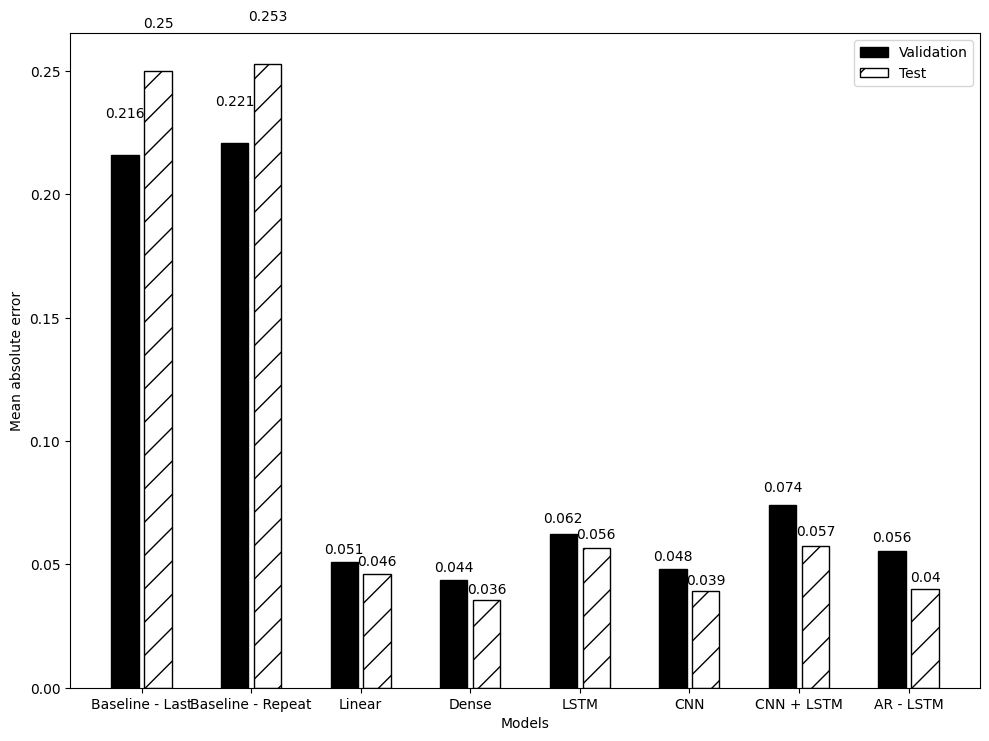

In [30]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+value*0.07, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+value*0.07, s=str(round(value, 3)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)